# Выбор глубины и числа фильтров для модели

## Содержание
* [Постановка задачи](#Постановка задачи)
* [Исследуемые параметры](#Исследуемые параметры)
* [Область значений параметра](#Область значений параметра)
* [Измеряемые характеристики](#Измеряемые характеристики)
* [Определение датасета](#Определение датасета)
* [Создание модели](#Создание модели)
* [Создание объекта research](#Создание объекта research)
* [Выводы](#Выводы)

## Постановка задачи
Выбрать параметры архитектуры CNN, классифицирующей  датасет MNIST.

## Исследуемые параметры
Глубина сети - число building block-ов заданной конфигурации, число фильтров конволюций.

## Область значений параметра
Число блоков: [2, 3, 4, 5].

Число фильтров в первой конволюции: [16, 32, 64].

## Измеряемые характеристики

Метрика accuracy на тестовой части датасета MNIST.

## Определение датасета
Создание датасета и, при необходимости, загрузка исходных данных.

In [1]:
!nvidia-smi

Tue Feb 26 11:00:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.78       Driver Version: 410.78       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:03:00.0 Off |                  N/A |
| 27%   30C    P8     9W / 180W |   1951MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
| 27%   32C    P8    11W / 180W |     10MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
%env CUDA_VISIBLE_DEVICES=6, 7

env: CUDA_VISIBLE_DEVICES=6, 7


In [4]:
import sys
import os
sys.path.insert(0, os.path.join("..", "..", ".."))

In [3]:
from copy import deepcopy
from itertools import combinations

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from radial.batchflow import Dataset, FilesIndex, Pipeline, R, B, V, C, action, inbatch_parallel
from radial.batchflow.models.tf import TFModel

from radial.batchflow.research import Research, Option
from radial.batchflow.research.research import Executable

from radial.core import RadialBatch, RadialImagesBatch
from radial.core.radial_batch import safe_src_dst_preprocess
from radial.core.pipelines import create_load_ppl

from research_utils import *
plt.style.use('ggplot')
%matplotlib inline

ImportError: No module named 'radial'

In [2]:
import glob
import dill

import numpy as np

from batchflow import Pipeline, B, V, C
from batchflow.opensets import MNIST
from batchflow.research import Option, Research, Results
from batchflow.models.tf import TFModel
from batchflow.models.tf.layers import conv_block

from src import get_accuracy, save_model, show_research

In [3]:
mnist_set = MNIST()

DownloadingDownloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz 
DownloadingExtracting /tmp/train-labels-idx1-ubyte.gz
 http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gzExtracting /tmp/train-images-idx3-ubyte.gz

Extracting /tmp/t10k-labels-idx1-ubyte.gz


## Обход датасета

- Отдельно выделяем корневой пайплайн, который будет общим для разных конфигураций модели.
- Определяем размер батча (64), фиксируем обход датасета, зафиксировав seed

In [4]:
BATCH_SIZE = 64

In [5]:
train_root = (Pipeline()
                .run(BATCH_SIZE, shuffle=True, n_epochs=None, lazy=True, seed=123) << mnist_set.train)
              
test_root = (Pipeline()
                .run(BATCH_SIZE, shuffle=True, n_epochs=1, lazy=True, seed=123) << mnist_set.test)

## Создание модели

Создадим небольшую CNN, передав параметры слоев в `model_config`. 
Параметры, которые будут варьироваться определяем как `C('parameter_name')`.

Мы варьируем `n_blocks` и `n_filters` - начальное число фильтров в первой конволюции. В каждой последующей конволюции число фильтров увеличивается в два раза.

Каждый блог имеет фиксированный `layout='cpna'`.

Также фиксируем алгоритм оптимизатора. Используем оптимизатор `Adam` (tf.train.AdamOptimizer) т.к. он часто используется в качестве бейзлайна.



In [6]:
NUM_CLASSES = 10

In [7]:
class ConvModel(TFModel):
    def body(cls, inputs, **kwargs):
        x = inputs
        for i in range(kwargs['n_blocks']):
            x = conv_block(x, 'cpna', filters=2 ** i * kwargs['n_filters'],
                           kernel_size=3, strides=2, pool_strides=1, name='block_' + str(i))
        return x

In [8]:
model_config = {
    'inputs': dict(images=dict(shape=B('image_shape')),
                   labels=dict(classes=NUM_CLASSES, transform='ohe', name='targets')),
    'body': dict(n_blocks=C('n_blocks'),
                 n_filters=C('n_filters')),
    'head': dict(layout='Pf', units=NUM_CLASSES),
    'initial_block/inputs': 'images',
    'loss': 'cross-entropy',
    'optimizer': 'Adam'}

Создадим пайплайн для обучения и теста.

In [9]:
train_template = (Pipeline()
                  .init_variable('loss', init_on_each_run=list)
                  .init_variable('accuracy', init_on_each_run=list)
                  .init_model('dynamic', ConvModel, 'mnist_model', config=model_config)
                  .to_array()
                  .train_model('mnist_model', fetches='loss',
                               feed_dict={'images': B('images'),
                                          'labels': B('labels')},
                               save_to=V('loss'), mode='w'))

test_template = (Pipeline()
                 .import_model('mnist_model', C('import_from'))
                 .init_variable('loss', init_on_each_run=list)
                 .init_variable('predictions', init_on_each_run=list)
                 .init_variable('metrics', init_on_each_run=None)
                 .to_array()
                 .predict_model('mnist_model', fetches=['loss', 'predictions'],
                                feed_dict={'images': B('images'),
                                           'labels': B('labels')},
                                save_to=[V('loss'), V('predictions')])
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                 fmt='logits', axis=-1, save_to=V('metrics'), mode='u'))

## Создание объекта research

Зададим параметры для запусков research. Добавим в research подсчет функции `get_accuracy`, которая будет выполнена каждые 50 итераций, получив результаты работы пайплайна c именем `test`

In [10]:
op1 = Option('n_blocks', [2, 3, 4, 5])
op2 = Option('n_filters', [16, 32, 64])
grid = op1 * op2

research = (Research()
            .pipeline(root=train_root, branch=train_template, variables='loss', name='train')
            .pipeline(root=test_root, branch=test_template,  variables='loss', name='test', execute='%50',
                      run=True, import_from='train')
            .grid(grid)
            .function(get_accuracy, returns='accuracy', name='test_accuracy',
                  execute='%50', pipeline='test'))

In [11]:
NUM_REPEAT = 3
NUM_ITERS = 400
research_name = 'blocks_filters_research'

In [12]:
research.run(n_reps=NUM_REPEAT, n_iters=NUM_ITERS, name=research_name, progress_bar=True)

Research blocks_filters_research is starting...


  0%|          | 0/14400 [00:00<?, ?it/s]

Distributor has 36 jobs with 400 iterations. Totally: 14400


100%|██████████| 14400/14400 [30:03<00:00,  7.98it/s]


## Обработка результатов:

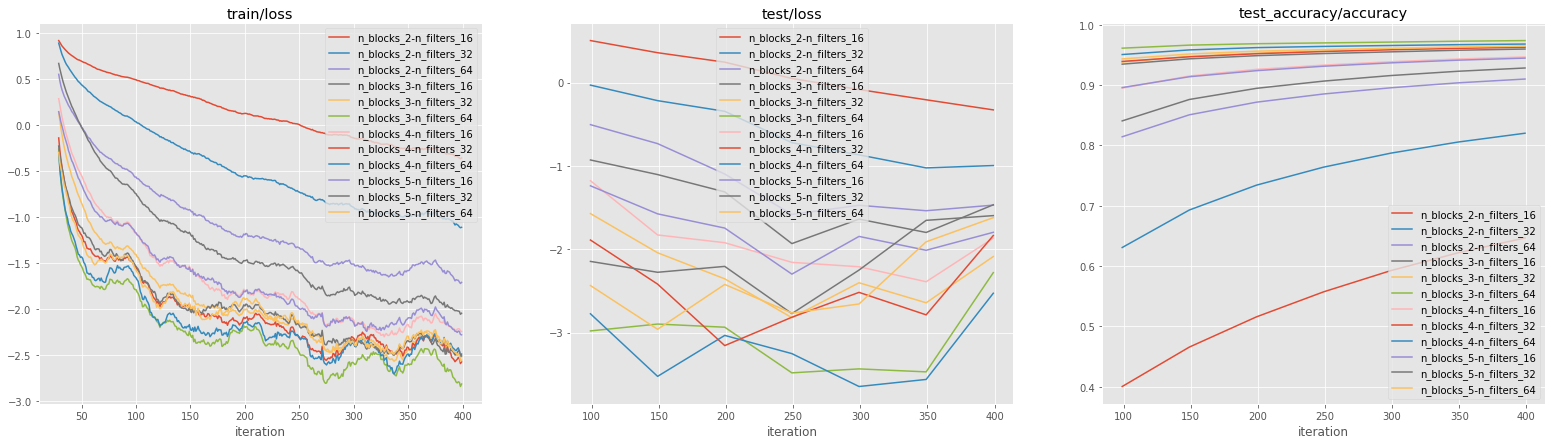

In [13]:
data = Results(path=research_name).load(use_alias=True)
show_research(data, average_repetitions=True, log_scale=[True, True, False],
              layout=['train/loss', 'test/loss', 'test_accuracy/accuracy'],
              rolling_window=[30, 2, 2])

## Выводы

Судя по графикам test loss и accuracy, можем определить, что лучшей оказалась модель с параметрами n_blocks=3, n_filters=64

Несмотря на то, что выбранная конфигурация модели в среднем оказалась лучше других, полезно, наряду с точечной оценкой, получить распределение метрики по N независимым запускам.